[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pachterlab/OBP_2025/blob/main/analysis_notebooks/matqseq_comparisons.ipynb)

# Clone Github Repo

In [ ]:
!git clone https://github.com/pachterlab/OBP_2025.git
%cd /content/OBP_2025/

In [ ]:
!pip install -qr requirements.txt

In [1]:
# import packages

import os, sys
sys.path.append('../')
from pathlib import Path

import re

# numbers
import numpy as np
import pandas as pd
import scipy

import anndata
import scanpy as sc

# plots
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def gtf2df(gtf: str, gff=True) -> pd.DataFrame:
    """
    Convert a GTF file to a pandas DataFrame.
    Tested with Ensemble GTF files.
    Parameters
    ----------
    gtf : str
        Path to the GTF file.
    Returns
    -------
    df : pandas.DataFrame
    Examples
    --------
    .. highlight:: python
    .. code-block:: pyt|hon
        df = gtf2df('ensembl.gtf')
        df.head()
    """

    df = pd.read_csv(gtf, sep='\t', header=None, comment='#')
    df.columns = ['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute']

    fields = ['ID', 'gene_id', 'Parent', 'Dbxref', 'Name', 'Ontology_term', 'locus_tag', 'old_locus_tag']
    for field in fields:
        if gff:
            df[field] = df['attribute'].apply(lambda x: re.findall(f'{field}=([^"]*)', x)[0].split(';')[0] if f'{field}=' in x else '')
        else:
            df[field] = df['attribute'].apply(lambda x: re.findall(f'{field} "[^"]*"', x)[0].split(' ')[1].split('"')[1] if f'{field} ' in x else '')

    df.replace('', np.nan, inplace=True)

    df.drop('attribute', axis=1, inplace=True)

    
    return df

# Load in Kb-python counts

In [ ]:
metadata = pd.read_csv('MATQseq/metadata.csv')
name_dict = {'OD 1.0': 'LEP', 'OD 0.3':'MEP', 'OD 0.1':'EEP', 'OD 2.0':'ESP'}
metadata['phase'] = [name_dict[x] for x in metadata.OD.values]
metadata.head()

,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,cell_type,Center Name,condition,...,Platform,ReleaseDate,create_date,version,Sample Name,Serovar,source_name,SRA Study,sub_species,phase
0,SRR22392848,RNA-Seq,101,1959116392,PRJNA904727,SAMN31851768,646138240,bacterial cell,HELMHOLTZ INSTITUTE FOR RNA-BASED INFECTION RE...,LEP,...,ILLUMINA,2023-02-09T00:00:00Z,2022-11-23T11:28:00Z,1,GSM6753713,Typhimurium,bacterial cell,SRP409450,enterica,LEP
1,SRR22392849,RNA-Seq,101,1877411432,PRJNA904727,SAMN31851769,618191964,bacterial cell,HELMHOLTZ INSTITUTE FOR RNA-BASED INFECTION RE...,LEP,...,ILLUMINA,2023-02-09T00:00:00Z,2022-11-23T11:28:00Z,1,GSM6753712,Typhimurium,bacterial cell,SRP409450,enterica,LEP
2,SRR22392850,RNA-Seq,101,876191564,PRJNA904727,SAMN31851770,281388138,bacterial cell,HELMHOLTZ INSTITUTE FOR RNA-BASED INFECTION RE...,LEP,...,ILLUMINA,2023-02-09T00:00:00Z,2022-11-23T11:25:00Z,1,GSM6753711,Typhimurium,bacterial cell,SRP409450,enterica,LEP
3,SRR22392851,RNA-Seq,101,1279332862,PRJNA904727,SAMN31851771,424162617,bacterial cell,HELMHOLTZ INSTITUTE FOR RNA-BASED INFECTION RE...,LEP,...,ILLUMINA,2023-02-09T00:00:00Z,2022-11-23T11:26:00Z,1,GSM6753710,Typhimurium,bacterial cell,SRP409450,enterica,LEP
4,SRR22392852,RNA-Seq,101,1010906778,PRJNA904727,SAMN31851772,331866105,bacterial cell,HELMHOLTZ INSTITUTE FOR RNA-BASED INFECTION RE...,LEP,...,ILLUMINA,2023-02-09T00:00:00Z,2022-11-23T11:26:00Z,1,GSM6753709,Typhimurium,bacterial cell,SRP409450,enterica,LEP


In [ ]:
adata = anndata.read_h5ad("MATQseq/kb_results/matqseq.h5ad")
adata

AnnData object with n_obs × n_vars = 384 × 4911
    obs: 'file', 'Assay Type', 'AvgSpotLen', 'Bases', 'BioProject', 'BioSample', 'Bytes', 'cell_type', 'Center Name', 'condition', 'Consent', 'DATASTORE filetype', 'DATASTORE provider', 'DATASTORE region', 'Experiment', 'Instrument', 'Library Name', 'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'media', 'OD', 'Organism', 'Platform', 'ReleaseDate', 'create_date', 'version', 'Sample Name', 'Serovar', 'source_name', 'SRA Study', 'sub_species', 'phase'
    layers: 'ambiguous', 'mature', 'nascent'

In [ ]:
kb_gtf = gtf2df('MATQseq/genome/salmonella_sl1344.gtf',gff=False)
kb_gtf = kb_gtf[kb_gtf['feature'] == 'mRNA'].groupby('gene_id').first().reset_index()
kb_gtf

/var/folders/kj/wm2vrp3x04qgzq18l2rkrcxh0000gn/T/ipykernel_70888/673987699.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('', np.nan, inplace=True)


,gene_id,seqname,source,feature,start,end,score,strand,frame,ID,Parent,Dbxref,Name,Ontology_term,locus_tag,old_locus_tag
0,agat-gene-10,FQ312003.1,AGAT,mRNA,9376,9942,.,-,.,gene-SL1344_0009,agat-gene-10,EnsemblGenomes-Gn:SL1344_0009,CBW16110.1,NaN,SL1344_0009,NaN
1,agat-gene-100,FQ312003.1,AGAT,mRNA,118080,119582,.,-,.,gene-SL1344_0102,agat-gene-100,EnsemblGenomes-Gn:SL1344_0102,CBW16205.1,NaN,SL1344_0102,NaN
2,agat-gene-1000,FQ312003.1,AGAT,mRNA,1130174,1130503,.,-,.,gene-SL1344_1024,agat-gene-1000,EnsemblGenomes-Gn:SL1344_1024,CBW17120.1,NaN,SL1344_1024,NaN
3,agat-gene-1001,FQ312003.1,AGAT,mRNA,1130590,1131168,.,-,.,gene-SL1344_1025,agat-gene-1001,EnsemblGenomes-Gn:SL1344_1025,CBW17121.1,NaN,SL1344_1025,NaN
4,agat-gene-1002,FQ312003.1,AGAT,mRNA,1131870,1132550,.,-,.,gene-SL1344_1026,agat-gene-1002,EnsemblGenomes-Gn:SL1344_1026,CBW17122.1,NaN,SL1344_1026,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4739,agat-pseudogene-77,HE654725.1,AGAT,mRNA,16979,17101,.,-,.,gene-SL1344_P2_0023,agat-pseudogene-77,None,None,NaN,SL1344_P2_0023,NaN
4740,agat-pseudogene-78,HE654725.1,AGAT,mRNA,18418,18730,.,+,.,gene-SL1344_P2_0026,agat-pseudogene-78,PSEUDO:CCF76835.1,None,NaN,SL1344_P2_0026,NaN
4741,agat-pseudogene-79,HE654725.1,AGAT,mRNA,22606,22898,.,+,.,gene-SL1344_P2_0034,agat-pseudogene-79,PSEUDO:CCF76843.1,None,NaN,SL1344_P2_0034,NaN
4742,agat-pseudogene-8,FQ312003.1,AGAT,mRNA,75091,75438,.,+,.,gene-SL1344_0066A,agat-pseudogene-8,PSEUDO:CBW16167.1,None,NaN,SL1344_0066A,NaN


In [6]:
adata.var['junction'] = ['_gene' in x for x in adata.var.index.values]
adata = adata[:,~adata.var.junction]
adata

View of AnnData object with n_obs × n_vars = 384 × 4911
    obs: 'file', 'Assay Type', 'AvgSpotLen', 'Bases', 'BioProject', 'BioSample', 'Bytes', 'cell_type', 'Center Name', 'condition', 'Consent', 'DATASTORE filetype', 'DATASTORE provider', 'DATASTORE region', 'Experiment', 'Instrument', 'Library Name', 'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'media', 'OD', 'Organism', 'Platform', 'ReleaseDate', 'create_date', 'version', 'Sample Name', 'Serovar', 'source_name', 'SRA Study', 'sub_species', 'phase'
    var: 'junction'
    layers: 'ambiguous', 'mature', 'nascent'

In [7]:
gene_df = adata.var.reset_index()
#gene_df['gene_id'] = gene_df.gene_id.str.split('.', expand = True)[1]
adata.var = pd.merge(gene_df, kb_gtf, on = 'gene_id', how = 'left').set_index('ID')
#adata = adata[:,~adata.var.index.isna()]
adata.var.head()

/Users/ConradOakes/miniconda3/envs/bac/lib/python3.13/functools.py:934: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


,gene_id,junction,seqname,source,feature,start,end,score,strand,frame,Parent,Dbxref,Name,Ontology_term,locus_tag,old_locus_tag
ID,,,,,,,,,,,,,,,,
gene-SL1344_0001,agat-gene-2,False,FQ312003.1,AGAT,mRNA,169.0,255.0,.,+,.,agat-gene-2,EnsemblGenomes-Gn:SL1344_0001,CBW16102.1,NaN,SL1344_0001,NaN
gene-SL1344_0002,agat-gene-3,False,FQ312003.1,AGAT,mRNA,337.0,2799.0,.,+,.,agat-gene-3,EnsemblGenomes-Gn:SL1344_0002,CBW16103.1,NaN,SL1344_0002,NaN
gene-SL1344_0003,agat-gene-4,False,FQ312003.1,AGAT,mRNA,2801.0,3730.0,.,+,.,agat-gene-4,EnsemblGenomes-Gn:SL1344_0003,CBW16104.1,NaN,SL1344_0003,NaN
gene-SL1344_0004,agat-gene-5,False,FQ312003.1,AGAT,mRNA,3734.0,5020.0,.,+,.,agat-gene-5,EnsemblGenomes-Gn:SL1344_0004,CBW16105.1,NaN,SL1344_0004,NaN
gene-SL1344_0005,agat-gene-6,False,FQ312003.1,AGAT,mRNA,5114.0,5887.0,.,-,.,agat-gene-6,EnsemblGenomes-Gn:SL1344_0005,CBW16106.1,NaN,SL1344_0005,NaN


# Load in Original Counts

In [ ]:
first = True
file = []
for x in Path('MATQseq/default_pipeline_results/featureCounts').rglob('*.count'):
    file += [str(x)[-19:-8]]
    if first:
        first_df = pd.read_csv(x, sep='\t', comment='#')
        final_df = first_df.iloc[:,-1]
        gene_df = first_df.iloc[:, :-1]
        first = False
    else:
        temp_df = pd.read_csv(x, sep='\t', comment='#').iloc[:,-1]
        final_df = pd.concat([final_df, temp_df], axis=1)
final_df.head()

,bowtie2_aligned/SRR22393065_1.bam,bowtie2_aligned/SRR22393075_1.bam,bowtie2_aligned/SRR22393007_1.bam,bowtie2_aligned/SRR22393017_1.bam,bowtie2_aligned/SRR22392866_1.bam,bowtie2_aligned/SRR22392876_1.bam,bowtie2_aligned/SRR22392882_1.bam,bowtie2_aligned/SRR22392892_1.bam,bowtie2_aligned/SRR22393122_1.bam,bowtie2_aligned/SRR22393132_1.bam,...,bowtie2_aligned/SRR22392969_1.bam,bowtie2_aligned/SRR22392979_1.bam,bowtie2_aligned/SRR22393070_1.bam,bowtie2_aligned/SRR22393108_1.bam,bowtie2_aligned/SRR22393060_1.bam,bowtie2_aligned/SRR22393118_1.bam,bowtie2_aligned/SRR22393012_1.bam,bowtie2_aligned/SRR22393002_1.bam,bowtie2_aligned/SRR22392873_1.bam,bowtie2_aligned/SRR22392863_1.bam
0,0,3,0,1,1,0,0,0,0,0,...,0,0,0,0,1,15,0,0,1,0
1,888,0,0,2,1,3,1,0,0,0,...,1,1,0,0,0,3,0,0,1,0
2,5,0,0,0,0,0,0,0,0,0,...,0,0,1,0,2,0,0,0,0,1
3,0,2,0,0,0,0,0,0,0,0,...,0,0,0,14,3,0,0,0,0,0
4,0,0,0,0,0,0,0,0,2,0,...,0,0,0,0,1,0,0,0,0,0


In [9]:
old_adata = anndata.AnnData(final_df.values.T, 
                obs = pd.DataFrame({'File': final_df.columns}),
                var = gene_df)
old_adata.obs.index = file
old_adata

/Users/ConradOakes/miniconda3/envs/bac/lib/python3.13/functools.py:934: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)
/Users/ConradOakes/miniconda3/envs/bac/lib/python3.13/functools.py:934: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


AnnData object with n_obs × n_vars = 303 × 4787
    obs: 'File'
    var: 'Geneid', 'Chr', 'Start', 'End', 'Strand', 'Length'

In [10]:
gene_df = old_adata.var.copy()
gene_df['gene_id'] = gene_df.Geneid.str.split('-', expand = True)[1]
gene_df.head()

,Geneid,Chr,Start,End,Strand,Length,gene_id
0,gene-SL1344_0001,FQ312003.1,169,255,+,87,SL1344_0001
1,gene-SL1344_0002,FQ312003.1,337,2799,+,2463,SL1344_0002
2,gene-SL1344_0003,FQ312003.1,2801,3730,+,930,SL1344_0003
3,gene-SL1344_0004,FQ312003.1,3734,5020,+,1287,SL1344_0004
4,gene-SL1344_0005,FQ312003.1,5114,5887,-,774,SL1344_0005


In [11]:
normal_gtf = gtf2df('../MATQseq/genome/salmonella_sl1344.gff3')
normal_gtf = normal_gtf[normal_gtf['feature'] == 'gene'].groupby('ID').first().reset_index()

/var/folders/kj/wm2vrp3x04qgzq18l2rkrcxh0000gn/T/ipykernel_70888/673987699.py:30: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace('', np.nan, inplace=True)


In [12]:
old_adata.var = pd.merge(gene_df, normal_gtf, left_on = ['Chr', 'Geneid'], right_on = ['seqname', 'ID'], how = 'left').set_index('ID')
old_adata.var.head()

/Users/ConradOakes/miniconda3/envs/bac/lib/python3.13/functools.py:934: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


,Geneid,Chr,Start,End,Strand,Length,gene_id_x,seqname,source,feature,...,score,strand,frame,gene_id_y,Parent,Dbxref,Name,Ontology_term,locus_tag,old_locus_tag
ID,,,,,,,,,,,,,,,,,,,,,
gene-SL1344_0001,gene-SL1344_0001,FQ312003.1,169,255,+,87,SL1344_0001,FQ312003.1,EMBL,gene,...,.,+,.,NaN,None,None,thrL,NaN,SL1344_0001,NaN
gene-SL1344_0002,gene-SL1344_0002,FQ312003.1,337,2799,+,2463,SL1344_0002,FQ312003.1,EMBL,gene,...,.,+,.,NaN,None,None,thrA,NaN,SL1344_0002,NaN
gene-SL1344_0003,gene-SL1344_0003,FQ312003.1,2801,3730,+,930,SL1344_0003,FQ312003.1,EMBL,gene,...,.,+,.,NaN,None,None,thrB,NaN,SL1344_0003,NaN
gene-SL1344_0004,gene-SL1344_0004,FQ312003.1,3734,5020,+,1287,SL1344_0004,FQ312003.1,EMBL,gene,...,.,+,.,NaN,None,None,thrC,NaN,SL1344_0004,NaN
gene-SL1344_0005,gene-SL1344_0005,FQ312003.1,5114,5887,-,774,SL1344_0005,FQ312003.1,EMBL,gene,...,.,-,.,NaN,None,None,yaaA,NaN,SL1344_0005,NaN


In [13]:
old_adata.obs = pd.merge(old_adata.obs.reset_index(), metadata, left_on='index', right_on='Run', how = 'left').set_index('index')
old_adata = old_adata[~old_adata.obs.index.isna()]
old_adata.obs.head()

,File,Run,Assay Type,AvgSpotLen,Bases,BioProject,BioSample,Bytes,cell_type,Center Name,...,Platform,ReleaseDate,create_date,version,Sample Name,Serovar,source_name,SRA Study,sub_species,phase
index,,,,,,,,,,,,,,,,,,,,,
SRR22393065,bowtie2_aligned/SRR22393065_1.bam,SRR22393065,RNA-Seq,101.0,1.411058e+09,PRJNA904727,SAMN31851924,463707425.0,bacterial cell,HELMHOLTZ INSTITUTE FOR RNA-BASED INFECTION RE...,...,ILLUMINA,2023-02-09T00:00:00Z,2022-11-23T11:27:00Z,1.0,GSM6753557,Typhimurium,bacterial cell,SRP409450,enterica,EEP
SRR22393075,bowtie2_aligned/SRR22393075_1.bam,SRR22393075,RNA-Seq,101.0,6.499599e+08,PRJNA904727,SAMN31851974,213045956.0,bacterial cell,HELMHOLTZ INSTITUTE FOR RNA-BASED INFECTION RE...,...,ILLUMINA,2023-02-09T00:00:00Z,2022-11-23T11:24:00Z,1.0,GSM6753507,Typhimurium,bacterial cell,SRP409450,enterica,EEP
SRR22393007,bowtie2_aligned/SRR22393007_1.bam,SRR22393007,RNA-Seq,101.0,6.999364e+08,PRJNA904727,SAMN31851848,225523482.0,bacterial cell,HELMHOLTZ INSTITUTE FOR RNA-BASED INFECTION RE...,...,ILLUMINA,2023-02-09T00:00:00Z,2022-11-23T11:26:00Z,1.0,GSM6753633,Typhimurium,bacterial cell,SRP409450,enterica,MEP
SRR22393017,bowtie2_aligned/SRR22393017_1.bam,SRR22393017,RNA-Seq,101.0,8.824410e+08,PRJNA904727,SAMN31851874,290531198.0,bacterial cell,HELMHOLTZ INSTITUTE FOR RNA-BASED INFECTION RE...,...,ILLUMINA,2023-02-09T00:00:00Z,2022-11-23T11:26:00Z,1.0,GSM6753607,Typhimurium,bacterial cell,SRP409450,enterica,MEP
SRR22392866,bowtie2_aligned/SRR22392866_1.bam,SRR22392866,RNA-Seq,101.0,8.725788e+08,PRJNA904727,SAMN31851810,277828498.0,bacterial cell,HELMHOLTZ INSTITUTE FOR RNA-BASED INFECTION RE...,...,ILLUMINA,2023-02-09T00:00:00Z,2022-11-23T11:26:00Z,1.0,GSM6753671,Typhimurium,bacterial cell,SRP409450,enterica,MEP


In [14]:
old_adata

View of AnnData object with n_obs × n_vars = 303 × 4787
    obs: 'File', 'Run', 'Assay Type', 'AvgSpotLen', 'Bases', 'BioProject', 'BioSample', 'Bytes', 'cell_type', 'Center Name', 'condition', 'Consent', 'DATASTORE filetype', 'DATASTORE provider', 'DATASTORE region', 'Experiment', 'Instrument', 'Library Name', 'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'media', 'OD', 'Organism', 'Platform', 'ReleaseDate', 'create_date', 'version', 'Sample Name', 'Serovar', 'source_name', 'SRA Study', 'sub_species', 'phase'
    var: 'Geneid', 'Chr', 'Start', 'End', 'Strand', 'Length', 'gene_id_x', 'seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'gene_id_y', 'Parent', 'Dbxref', 'Name', 'Ontology_term', 'locus_tag', 'old_locus_tag'

In [15]:
def make_comp_graph(x_list, y_list, x_name, y_name, 
                    title = None, save = None, log=False):
    if log:
        y = np.log2([y+1 for y in y_list])
        x = np.log2([x+1 for x in x_list])
    else:
        x = x_list
        y = y_list
    pr, p = scipy.stats.pearsonr(x,y)   # Pearson's r
    rho = scipy.stats.spearmanr(x,y).correlation   # Spearman's rho
    tau = scipy.stats.kendalltau(x, y)[0]  # Kendall's tau
    m, b = np.polyfit(x, y, 1)
    print(f"Comparing {x_name} to {y_name}")
    print(f"Pearson's r: {pr, p}")
    print(f"Spearman's rho: {rho}")
    print(f"Kendall's tau: {tau}")
    y_true = y
    y_pred = x
    cor = np.corrcoef(y_true, y_pred)[0][1]
    # Means
    mean_true = np.mean(y_true)
    mean_pred = np.mean(y_pred)
    # Population variances
    var_true = np.var(y_true)
    var_pred = np.var(y_pred)
    # Population standard deviations
    sd_true = np.std(y_true)
    sd_pred = np.std(y_pred)
    # Calculate CCC
    numerator = 2 * cor * sd_true * sd_pred
    denominator = var_true + var_pred + (mean_true - mean_pred)**2
    ccc = numerator / denominator
    fig, ax = plt.subplots(figsize=(6, 6))
    plt.hexbin(x, y, gridsize=100, cmap='jet', bins='log')
    plt.plot([np.max([int(min(x)), int(min(y))]), np.min([int(max(x)), int(max(y))])],
             [np.max([int(min(x)), int(min(y))]), np.min([int(max(x)), int(max(y))])],
             label='y=x\nCCC '+str(round(ccc,2)))
    plt.colorbar(label='# of transcripts/bin')
    plt.xlabel(f"{x_name}")
    plt.ylabel(f"{y_name}")
    if title is not None:
        plt.title(title)
    plt.plot(x, [m*l+b for l in x], c='r', label='Regression line\nPearson R'+str(round(pr,2))+'\nSpearman '+r"$\rho$"+' '+str(round(rho,2)))
    plt.legend(loc='upper left')
    if save is not None:
        plt.savefig(save)
    plt.show()
    plt.close()

In [16]:
adata = adata[:,~adata.var.index.isna()]
old_adata = old_adata[:,~old_adata.var.index.isna()]

adata = adata[:, ~adata.var.index.duplicated()]
old_adata = old_adata[:, ~old_adata.var.index.duplicated()]
old_adata

View of AnnData object with n_obs × n_vars = 303 × 4787
    obs: 'File', 'Run', 'Assay Type', 'AvgSpotLen', 'Bases', 'BioProject', 'BioSample', 'Bytes', 'cell_type', 'Center Name', 'condition', 'Consent', 'DATASTORE filetype', 'DATASTORE provider', 'DATASTORE region', 'Experiment', 'Instrument', 'Library Name', 'LibraryLayout', 'LibrarySelection', 'LibrarySource', 'media', 'OD', 'Organism', 'Platform', 'ReleaseDate', 'create_date', 'version', 'Sample Name', 'Serovar', 'source_name', 'SRA Study', 'sub_species', 'phase'
    var: 'Geneid', 'Chr', 'Start', 'End', 'Strand', 'Length', 'gene_id_x', 'seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'gene_id_y', 'Parent', 'Dbxref', 'Name', 'Ontology_term', 'locus_tag', 'old_locus_tag'

In [17]:
var_intersect = old_adata.var_names.intersection(adata.var_names)#[0:1000]
obs_intersect = old_adata.obs_names.intersection(adata.obs_names)

Comparing Matqseq Pipeline Counts to Kb-python Counts
Pearson's r: (np.float64(0.9899348050173812), np.float64(0.0))
Spearman's rho: 0.9523593301242944
Kendall's tau: 0.9468016658656342


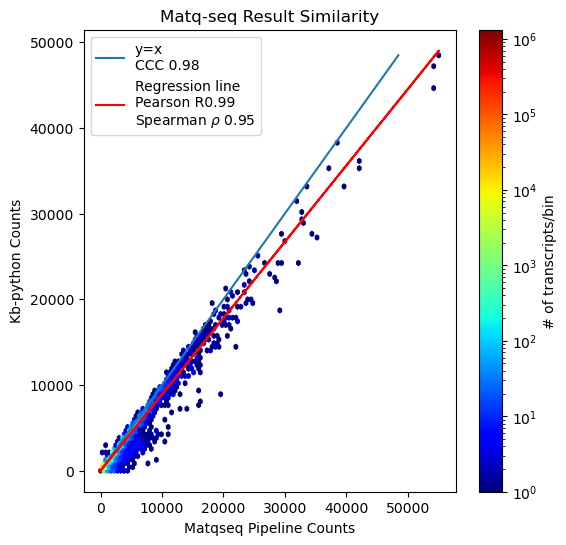

In [18]:
filtered_old_adata = old_adata[obs_intersect, var_intersect].copy()
filtered_adata = adata[obs_intersect, var_intersect].copy()

make_comp_graph(filtered_old_adata.X.reshape(-1, 1).T[0], filtered_adata.X.toarray().reshape(-1, 1).T[0],
               'Matqseq Pipeline Counts', 'Kb-python Counts', 'Matq-seq Result Similarity')

/Users/ConradOakes/miniconda3/envs/bac/lib/python3.13/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number
/Users/ConradOakes/miniconda3/envs/bac/lib/python3.13/site-packages/scanpy/preprocessing/_simple.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["n_genes"] = number


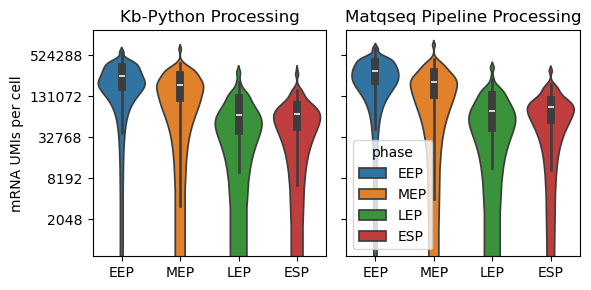

In [19]:
sc.pp.filter_cells(adata, min_genes=15)
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.filter_cells(old_adata, min_genes=15)
sc.pp.filter_genes(old_adata, min_cells=10)
adata.obs['umi'] = adata.X.sum(axis=1)
old_adata.obs['umi'] = old_adata.X.sum(axis=1)
adata.obs['phase'] = pd.Categorical(adata.obs.phase, ['EEP', 'MEP', 'LEP', 'ESP'])
old_adata.obs['phase'] = pd.Categorical(old_adata.obs.phase, ['EEP', 'MEP', 'LEP', 'ESP'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), sharey=True)
sns.violinplot(adata.obs, x = 'phase', y = 'umi', hue = 'phase',
              ax = ax1)
sns.violinplot(old_adata.obs, x = 'phase', y = 'umi', hue = 'phase',
              ax = ax2)
ax1.set_yscale('log', base=2)
#ax1.set_yticks([2**x for x in range(0, 11)])
from matplotlib.ticker import ScalarFormatter
for axis in [ax1.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax1.set_ylabel('mRNA UMIs per cell')

ax1.set_xlabel('')
ax2.set_xlabel('')


ax1.set_title('Kb-Python Processing')
ax2.set_title('Matqseq Pipeline Processing')
plt.tight_layout()